# Final Model (6sense)
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#findings">Findings</a></li>
    <ul>
    <li><a href="#1">Finding 1</a></li> 
    <li><a href="#2">Finding 2</a></li> 
    </ul>
<li><a href="#data">Data Pre-processing</a></li> 
    <ul>
    <li><a href="merge">Merge Table</a></li> 
    </ul>
<li><a href="#model">Building Model</a></li> 
    <ul>
    <li><a href="#knn">KNN</a></li> 
    <li><a href="#log">Logistic Regression</a></li> 
    <li><a href="#svm">SVM</a></li>
    <li><a href="#tree">Decision Tree</a></li>
    <li><a href="#ran">Random Forest</a></li>
    <li><a href="#ada">AdaBoost</a></li>
    <li><a href="#xgb">XGBoost</a></li>
    <li><a href="#gbm">LightGBM Classifier</a></li>
    <li><a href="#roc">ROC Curves</a></li> 
    </ul>
<li><a href="#con">Conclusion</a></li>     
</ul>

<a id='intro'></a>
## Introduction
> This notebook is for training the 6sense data through different models (such as Random Froest, KNN, XGBoost and so on) and find the best fit model through several variables including call disposition, best day of week to call and best hour to call, predicting the success or not if a customer would pick up phone calls so that the company can get engagement with prospective customers.

In [133]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn import svm,tree

In [123]:
#import data
calls = pd.read_csv('calls.csv')
companies = pd.read_csv('companies.csv')
events = pd.read_csv('events.csv')
opportunies = pd.read_csv('opportunities.csv')
people = pd.read_csv('people.csv')

<a id='findings'></a>
# Findings 
> There are two new findings based on our dataset.
<a id='1'></a>
## Finding 1: The most activities (194 times) company did not pick up 5 phone calls. 

In [124]:
#sorted sum of the events for grouped id
event_counts_by_id = events.groupby('contact_id').count().sort_values('date', ascending=False).reset_index().drop(['date','activity_type'], axis=1)
event_counts_by_id

,contact_id,activity_action
0,7505295075260161764,194
1,6357049929604753860,180
2,2323650454700737097,147
3,5610714029673303456,143
4,5873495652945372648,143
...,...,...
22246,5093462128937294245,1
22247,5090638181239071626,1
22248,2754883680870950698,1
22249,8433994941758218844,1


In [125]:
#the call response with most events company
calls.query("contact_id == 7505295075260161764")

,date,call_disposition,contact_id
290842,2019-09-05,No Answer,7505295075260161764
290843,2019-09-05,No Answer,7505295075260161764
290844,2019-11-01,No Answer,7505295075260161764
290845,2019-12-16,No Answer,7505295075260161764


<a id='2'></a>
## Finding 2: Scatterplot Display

### Important Step: Mapping the Positive Variables

In [26]:
calls.call_disposition.value_counts()

No Answer                         314912
Left Voicemail                     14671
Bad Number                          7114
Call Back Later                     6571
MC - No Need                        5370
MC - Meaningful Conversation        5138
MC - MQL/QMA                        2598
Left Live Message                   2415
MC - No Timeline                    1836
MC - Meeting Confirmation           1356
MC - No Authority                   1129
Wrong Point of Contact              1018
No Longer w/ Company                 995
Discovery Call Scheduled             981
MC - No Budget                       476
MC - No Technical Fit                293
Voicemail- Left Voicemail Drop       186
Call - No Answer                      38
MC - Call Back                         1
Name: call_disposition, dtype: int64

In [27]:
#if positive responses return 1 in call_disposition column
def get_pos(x):
    if x == 'MC - Meaningful Conversation':
        return 1
    elif x == 'MC - Meeting Confirmation':
        return 1
    elif x == 'MC - MQL/QMA':
        return 1
    elif x == 'MC - No Need':
        return 1
    elif x == 'MC - No Authority':
        return 1
    elif x == 'MC - No Budget':
        return 1
    elif x == 'MC - No Timeline':
        return 1
    elif x == 'MC - No Technical Fit':
        return 1
    elif x == 'MC - Call Back':
        return 1
    else:
        return 0

In [28]:
#sum up the positive responses to call_disposition
calls_temp = calls.copy()
calls_temp.call_disposition = calls_temp.call_disposition.apply(get_pos)
calls_temp = calls_temp.drop('date', axis=1).groupby('contact_id').sum().reset_index()
calls_temp.head()

,contact_id,call_disposition
0,166566594430710,0
1,266253115414781,0
2,638342195131369,0
3,958870857640301,0
4,1005177608297129,0


In [29]:
# value counts for each positive responses
calls_temp['call_disposition'].value_counts()

0     50517
1     11434
2      1915
3       534
4       160
5        55
6        27
7         9
9         3
8         2
11        2
12        2
19        1
10        1
13        1
14        1
18        1
28        1
Name: call_disposition, dtype: int64

In [31]:
#find out the relationship between call response and events times
#combine call and events table
combined = calls_temp.merge(event_counts_by_id, on='contact_id', how='left')
combined = combined.dropna()
combined

,contact_id,call_disposition,activity_action
5,1087052746460939,0,4.0
9,1725649318096176,1,2.0
13,2172390189079170,1,2.0
14,2281871236130720,0,1.0
15,2497165314871410,0,7.0
...,...,...,...
64650,9220737175662006854,1,2.0
64651,9220988583412404301,0,19.0
64654,9221365981464707787,1,2.0
64655,9221691394698869671,1,11.0


In [32]:
combined['call_disposition'].value_counts()

0     13604
1      6722
2      1341
3       396
4       110
5        48
6        15
7         9
12        2
13        1
28        1
8         1
19        1
Name: call_disposition, dtype: int64

In [33]:
combined[combined['call_disposition'] > 0].shape[0]

8647

In [34]:
combined.shape[0]

22251

In [35]:
combined[combined['call_disposition'] > 0].shape[0] / combined.shape[0]

0.38861174778661633

We have 8647 positive responses over 22251 calls. Only 38.9% rows are meaningful conversation.

In [36]:
# calls.query("call_disposition == 'MC - Meaningful Conversation'")

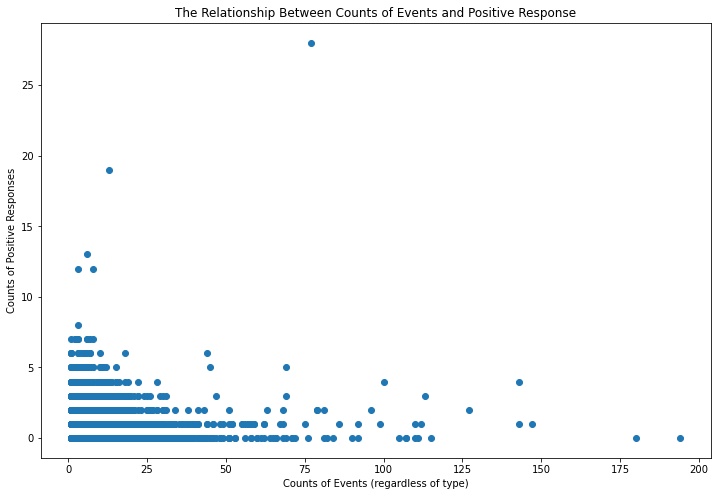

In [37]:
#draw scatterplot 
plt.figure(figsize=(12,8))
plt.scatter(combined.activity_action, combined.call_disposition)
plt.title('The Relationship Between Counts of Events and Positive Response')
plt.xlabel('Counts of Events (regardless of type)')
plt.ylabel('Counts of Positive Responses')
plt.show()

Based on the scatterplot:
1. Most companies have many counts of events and no positive responses.
2. Only few of the companies have high positive responses.

<a id='data'></a>
# Data Pre-processing
The data from 6sense:
<ul>
<li>calls.csv: a timeline of outgoing sales calls and the disposition of those calls</li>
<li>events.csv: any activities that we have on record taking place before the phone calls were made</li>
<li>companies.csv: the industry and employee count of the companies</li>
<li>people.csv: the people who were called, along with their job level and function and the ID of the company they work for</li>
<li>opportunities.csv: the date an opportunity was generated for a contact</li>
</ul>

> <b>In this part, we will gather three parts of data</b>

### 1. Calls table
<ul>
    <li>Add weekday columns.</li>
    <li>Map positive response of phone calls and calculate the sum.</li>
    <li>Find out max and min duration of each call date. </li>
</ul>

In [38]:
type(calls.date[0])

str

In [39]:
#change the date from string to datetime
new_calls = calls.copy()
new_calls['date'] = pd.to_datetime(new_calls['date'], format='%Y-%m-%d')
new_calls

,date,call_disposition,contact_id
0,2019-10-25,Left Voicemail,8820954680632966332
1,2019-10-25,No Answer,8820954680632966332
2,2019-10-28,Call Back Later,9085041672616908600
3,2019-07-31,Bad Number,6174483391018071888
4,2019-09-26,No Answer,6174483391018071888
...,...,...,...
367093,2019-09-02,No Answer,557663644881937749
367094,2019-09-02,No Answer,557663644881937749
367095,2019-09-03,MC - MQL/QMA,557663644881937749
367096,2019-09-03,No Answer,557663644881937749


In [40]:
#add weekday column (Monday is 0 and Sunday is 6) [this tbl is not unique id]
weekday = []
for i in new_calls['date']:
    weekday.append(i.weekday())
new_calls['weekday'] = weekday   
new_calls

,date,call_disposition,contact_id,weekday
0,2019-10-25,Left Voicemail,8820954680632966332,4
1,2019-10-25,No Answer,8820954680632966332,4
2,2019-10-28,Call Back Later,9085041672616908600,0
3,2019-07-31,Bad Number,6174483391018071888,2
4,2019-09-26,No Answer,6174483391018071888,3
...,...,...,...,...
367093,2019-09-02,No Answer,557663644881937749,0
367094,2019-09-02,No Answer,557663644881937749,0
367095,2019-09-03,MC - MQL/QMA,557663644881937749,1
367096,2019-09-03,No Answer,557663644881937749,1


In [41]:
#positive responses
def get_pos(x):
    if x == 'MC - Meaningful Conversation':
        return 1
    elif x == 'MC - Meeting Confirmation':
        return 1
    elif x == 'MC - MQL/QMA':
        return 1
    elif x == 'MC - No Need':
        return 1
    elif x == 'MC - No Authority':
        return 1
    elif x == 'MC - No Budget':
        return 1
    elif x == 'MC - No Timeline':
        return 1
    elif x == 'MC - No Technical Fit':
        return 1
    elif x == 'MC - Call Back':
        return 1
    else:
        return 0

In [42]:
#sum of the positive responses with unique id
new_calls_disposition = new_calls.copy()
new_calls_disposition.call_disposition = new_calls_disposition.call_disposition.apply(get_pos)
new_calls_disposition = new_calls_disposition.drop(['date', 'weekday'], axis=1).groupby('contact_id').sum().sort_values('call_disposition', ascending=False).reset_index()
new_calls_disposition.head()

,contact_id,call_disposition
0,866659017680622750,28
1,2974518792887422733,19
2,5689916162122230730,18
3,2563817588376783298,14
4,3831961766320141998,13


In [43]:
#get the most frequency of weekday with unique id
new_calls_weekday = new_calls.copy()
new_calls_weekday = new_calls_weekday.drop(['date', 'call_disposition'], axis=1).groupby(['contact_id']).agg(lambda x:x.value_counts().index[0])
new_calls_weekday.head()

,weekday
contact_id,
166566594430710,0
266253115414781,2
638342195131369,3
958870857640301,4
1005177608297129,3


In [72]:
#find out max and min duration of each call date 
min_diff = []
max_diff = []
unique_contact = new_calls["contact_id"].unique()
for i in unique_contact:
    max_diff = np.append(max_diff, max(new_calls[new_calls["contact_id"] == i]["date"].sort_values(ascending = True).diff().fillna(pd.Timedelta(seconds=0)).dt.days))
    min_diff = np.append(min_diff, min(new_calls[new_calls["contact_id"] == i]["date"].sort_values(ascending = True).diff().fillna(pd.Timedelta(seconds=0)).dt.days))

In [76]:
max_min_call = pd.DataFrame({'contact_id' : new_calls["contact_id"].unique(), 'min_diff_call' : min_diff, 'max_diff_call' : max_diff})
max_min_call

,contact_id,min_diff_call,max_diff_call
0,8820954680632966332,0.0,0.0
1,9085041672616908600,0.0,0.0
2,6174483391018071888,0.0,57.0
3,1848273219698443716,0.0,0.0
4,2860445931853436299,0.0,31.0
...,...,...,...
64661,4940377251660283934,0.0,0.0
64662,8840267864814248410,0.0,0.0
64663,6710892354401621019,0.0,5.0
64664,5303732118592177571,0.0,48.0


In [84]:
#duration of call (last day call - first day call)
new_calls_time = new_calls.groupby(['contact_id']).agg(lambda x: max(x) - min(x)).sort_values('date', ascending=False).reset_index()
new_calls_time

,contact_id,date,weekday
0,1788315889737511044,183 days,4
1,8468023606453927141,183 days,4
2,2680561098649963168,183 days,6
3,4197057779527445661,183 days,3
4,2540645441967285227,183 days,3
...,...,...,...
64661,6383302405961648920,0 days,0
64662,3020354175357105751,0 days,0
64663,6383079103058674949,0 days,0
64664,3020555656802007664,0 days,0


In [85]:
#double check if it is true
new_calls.query('contact_id == 166566594430710')

,date,call_disposition,contact_id,weekday
281395,2019-12-30,No Answer,166566594430710,0
281396,2019-12-16,No Answer,166566594430710,0


In [86]:
#merge the new_calls_time and new_calls_disposition
new_calls_merge = new_calls_disposition.merge(new_calls_time, on='contact_id', how='left')
new_calls_merge

,contact_id,call_disposition,date,weekday
0,866659017680622750,28,131 days,4
1,2974518792887422733,19,103 days,4
2,5689916162122230730,18,156 days,4
3,2563817588376783298,14,106 days,4
4,3831961766320141998,13,87 days,4
...,...,...,...,...
64661,3471346052708762864,0,0 days,0
64662,3471354230762302850,0,1 days,1
64663,3471457119889776084,0,0 days,0
64664,3471582995302861547,0,14 days,4


### 2. People table & Companies table
<ul>
    <li>Merge two table based on contact_id.</li>
    <li>Apply numerical features to job_level (numerical 0 - Other, 1 - Staff ...)</li>
    <li>One-hot encoding based on industry.</li>
</ul>

In [106]:
#merge the people and companies with the unique company_id
pplcomp = people.merge(companies, on = ['company_id'])
pplcomp.head(10)

,job_level,job_function,company_id,contact_id,industry,employee_range
0,Manager,Operations,b9870ba24bb001c,1607962447045298548,Healthcare and Medical,100 - 249
1,Director,Finance,b9870ba24bb001c,4651403782582719025,Healthcare and Medical,100 - 249
2,Staff,Operations,c621a5f1e6166a7,5027514905586639586,Transportation and Logistics,"1,000 - 4,999"
3,Director,Operations,c621a5f1e6166a7,9134642806902301168,Transportation and Logistics,"1,000 - 4,999"
4,Manager,Accounting,c621a5f1e6166a7,5448432040507773802,Transportation and Logistics,"1,000 - 4,999"
5,Director,Operations,c621a5f1e6166a7,5329546946592507962,Transportation and Logistics,"1,000 - 4,999"
6,Vice President,Finance,c621a5f1e6166a7,4615094679149225512,Transportation and Logistics,"1,000 - 4,999"
7,Vice President,Engineering,c621a5f1e6166a7,1791435625063169311,Transportation and Logistics,"1,000 - 4,999"
8,Director,Operations,c621a5f1e6166a7,2627507836180836943,Transportation and Logistics,"1,000 - 4,999"
9,Director,Management,c621a5f1e6166a7,1670775986298395853,Transportation and Logistics,"1,000 - 4,999"


In [107]:
#apply numerical features to job_level (numerical 0 - Other, 1 - Staff ...)
job_level_convert = {"Other" :0, "Staff":1, "Manager":2, "Director":3, "Senior":4, "Vice President":5, "C-Level":6}
pplcomp["job_level"] = pplcomp["job_level"].map(job_level_convert)   
pplcomp.head(10)

,job_level,job_function,company_id,contact_id,industry,employee_range
0,2,Operations,b9870ba24bb001c,1607962447045298548,Healthcare and Medical,100 - 249
1,3,Finance,b9870ba24bb001c,4651403782582719025,Healthcare and Medical,100 - 249
2,1,Operations,c621a5f1e6166a7,5027514905586639586,Transportation and Logistics,"1,000 - 4,999"
3,3,Operations,c621a5f1e6166a7,9134642806902301168,Transportation and Logistics,"1,000 - 4,999"
4,2,Accounting,c621a5f1e6166a7,5448432040507773802,Transportation and Logistics,"1,000 - 4,999"
5,3,Operations,c621a5f1e6166a7,5329546946592507962,Transportation and Logistics,"1,000 - 4,999"
6,5,Finance,c621a5f1e6166a7,4615094679149225512,Transportation and Logistics,"1,000 - 4,999"
7,5,Engineering,c621a5f1e6166a7,1791435625063169311,Transportation and Logistics,"1,000 - 4,999"
8,3,Operations,c621a5f1e6166a7,2627507836180836943,Transportation and Logistics,"1,000 - 4,999"
9,3,Management,c621a5f1e6166a7,1670775986298395853,Transportation and Logistics,"1,000 - 4,999"


In [108]:
#one-hot encoding based on industry (one-hot encoding)
dum_industry = pd.get_dummies(pplcomp["industry"])
pplcomp = pplcomp.drop(["industry"],axis=1).merge(dum_industry,left_index = True,right_index=True)
pplcomp.head(10)

,job_level,job_function,company_id,contact_id,employee_range,Aerospace and Defense,Agriculture,Apparel,Associations,Automotive,...,Mining,Pharmaceuticals,Printing and Publishing,Real Estate,Recreation,Retail and Distribution,Software and Technology,Telecommunications,Textiles,Transportation and Logistics
0,2,Operations,b9870ba24bb001c,1607962447045298548,100 - 249,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,Finance,b9870ba24bb001c,4651403782582719025,100 - 249,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Operations,c621a5f1e6166a7,5027514905586639586,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,Operations,c621a5f1e6166a7,9134642806902301168,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,Accounting,c621a5f1e6166a7,5448432040507773802,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,3,Operations,c621a5f1e6166a7,5329546946592507962,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,5,Finance,c621a5f1e6166a7,4615094679149225512,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,5,Engineering,c621a5f1e6166a7,1791435625063169311,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,3,Operations,c621a5f1e6166a7,2627507836180836943,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,3,Management,c621a5f1e6166a7,1670775986298395853,"1,000 - 4,999",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [110]:
#drop useless columns
new_merge_people_companies = pplcomp.drop(['job_function', 'employee_range', 'company_id'], axis=1)
new_merge_people_companies

,job_level,contact_id,Aerospace and Defense,Agriculture,Apparel,Associations,Automotive,Biotech,Business Services,Construction,...,Mining,Pharmaceuticals,Printing and Publishing,Real Estate,Recreation,Retail and Distribution,Software and Technology,Telecommunications,Textiles,Transportation and Logistics
0,2,1607962447045298548,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,4651403782582719025,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5027514905586639586,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,9134642806902301168,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,5448432040507773802,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64424,3,5510743444500674061,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
64425,0,5776926533119273361,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64426,0,8325433126987306458,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
64427,3,6748736308055031437,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### 3. Events Table
<ul>
    <li>Find out max and min duration of each event date.</li>
    <li>Calculate the duration of events (last day events - first day events)</li>
</ul>

In [87]:
new_events = events.copy()
new_events['date'] = pd.to_datetime(new_events['date'], format='%Y-%m-%d')
new_events.head()

,date,activity_action,activity_type,contact_id
0,2019-04-24,view,known_web_visit,4108398267771616228
1,2019-04-24,view,known_web_visit,1615093602351989804
2,2019-04-24,view,known_web_visit,8031730183355860699
3,2019-04-24,fill_out,form_fill,5975401237816306305
4,2019-04-24,fill_out,form_fill,3743028858149856355


In [93]:
#find out max and min duration of call date 
min_diff_events = []
max_diff_events = []
unique_contacts = new_events["contact_id"].unique()
for i in unique_contacts:
    max_diff_events = np.append(max_diff_events, max(new_events[new_events["contact_id"] == i]["date"].sort_values(ascending = True).diff().fillna(pd.Timedelta(seconds=0)).dt.days))
    min_diff_events = np.append(min_diff_events, min(new_events[new_events["contact_id"] == i]["date"].sort_values(ascending = True).diff().fillna(pd.Timedelta(seconds=0)).dt.days))
max_min_events = pd.DataFrame({'contact_id' : new_events["contact_id"].unique(), 'min_diff_events' : min_diff_events, 'max_diff_events' : max_diff_events})
max_min_events

,contact_id,min_diff_events,max_diff_events
0,4108398267771616228,0.0,40.0
1,1615093602351989804,0.0,35.0
2,8031730183355860699,0.0,35.0
3,5975401237816306305,0.0,8.0
4,3743028858149856355,0.0,143.0
...,...,...,...
22246,7560512012730536240,0.0,0.0
22247,5593935890842632651,0.0,0.0
22248,2039156972335861496,0.0,0.0
22249,6444183784227299839,0.0,0.0


In [88]:
#calculate the duration of events (last day events - first day events)
new_events_time_temp = new_events.groupby(['contact_id']).agg(lambda x: max(x) - min(x)).sort_values('date', ascending=False).reset_index()
new_events_time_temp

,contact_id,date
0,1415788574014422038,335 days
1,8589813686327644231,335 days
2,2840799196508399016,330 days
3,6456597479048152312,330 days
4,5687714639638044912,325 days
...,...,...
22246,4836069608754815172,0 days
22247,4836211839472306087,0 days
22248,4837219643221673356,0 days
22249,1042133571770950338,0 days


In [89]:
new_events_time = new_events_time_temp.merge(combined, on='contact_id').drop('call_disposition', axis=1)
new_events_time

,contact_id,date,activity_action
0,1415788574014422038,335 days,22.0
1,8589813686327644231,335 days,27.0
2,2840799196508399016,330 days,42.0
3,6456597479048152312,330 days,64.0
4,5687714639638044912,325 days,38.0
...,...,...,...
22246,4836069608754815172,0 days,4.0
22247,4836211839472306087,0 days,4.0
22248,4837219643221673356,0 days,3.0
22249,1042133571770950338,0 days,3.0


# Merge All Tables

In [178]:
#merge unique contact_id with these two new table
combine_time = new_calls_merge.merge(new_events_time, on='contact_id',how='left').rename(columns={'date_x':'calls_time', 'date_y':'events_time'})
combine_time = combine_time.merge(new_calls_weekday, on='contact_id',how='left').rename(columns={'weekday_y':'weekday'}).drop('weekday_x', axis=1)
combine_time = combine_time.merge(max_min_call, on='contact_id',how='left')
combine_time = combine_time.merge(max_min_events, on='contact_id',how='left')
combine_time = combine_time.merge(new_merge_people_companies, on='contact_id',how='left')
#set the success to 1, fail to 0
success = []
for i in combine_time['call_disposition']:
    if i > 0:
        success = np.append(success, 1)
    else:
        success = np.append(success, 0)

#new column success
combine_time['success'] = success
combine_time['calls_time'] = pd.to_timedelta(combine_time.calls_time, errors='coerce').dt.days
combine_time['events_time'] = pd.to_timedelta(combine_time.events_time, errors='coerce').dt.days.fillna(0)
combine_time['activity_action'] = combine_time['activity_action'].fillna(0)
combine_time['min_diff_events'] = combine_time['min_diff_events'].fillna(0)
combine_time['max_diff_events'] = combine_time['max_diff_events'].fillna(0)

<a id='merge'></a>
# Feature: Description

<ul>
<li><b>call_disposition:</b>  sum of the positive response</li>
    
<li><b>calls_time:</b>  duration of all calls (last day call - first day call)</li>
    
<li><b>events_time:</b>  duration of all events (last day event - first day event)</li>

<li><b>activity_action: </b> sum of the event times</li>

<li><b>weekday: </b> the most frequent of weekday with each id</li>

<li><b>min_diff_call:</b>  minimum duration between two consecutive call dates </li>

<li><b>max_diff_call:</b>  maximum duration between two consecutive call dates </li>   

<li><b>min_diff_events:</b>  minimum duration between two consecutive event dates </li>

<li><b>max_diff_events:</b>  maximum duration between two consecutive event dates    </li>

<li><b>job_level:</b>  numerical features of job_level (0 - Other, 1 - Staff, 2 - Manager, 3 - Director, 4 - Senior, 5 - Vice President, 6 - C-Level)</li>
    
<li><b>success: </b> 1 - positive response, 0 - negative response</li>

<li><b>Industry (one-hot encoding features):</b> 
       'Aerospace and Defense', 'Agriculture', 'Apparel', 'Associations',
       'Automotive', 'Biotech', 'Business Services', 'Construction',
       'Consumer Goods and Services', 'Education', 'Energy and Utilities',
       'Financial Services', 'Food and Beverage', 'Furniture', 'Government',
       'Hardware', 'Healthcare and Medical', 'Home and Garden',
       'Hospitality and Travel', 'Manufacturing', 'Media and Entertainment',
       'Mining', 'Pharmaceuticals', 'Printing and Publishing', 'Real Estate',
       'Recreation', 'Retail and Distribution', 'Software and Technology',
       'Telecommunications', 'Textiles', 'Transportation and Logistics',
       'success'</li>
</ul>




In [181]:
#merge table
combine_time

,contact_id,call_disposition,calls_time,events_time,activity_action,weekday,min_diff_call,max_diff_call,min_diff_events,max_diff_events,...,Pharmaceuticals,Printing and Publishing,Real Estate,Recreation,Retail and Distribution,Software and Technology,Telecommunications,Textiles,Transportation and Logistics,success
0,866659017680622750,28,131,300.0,77.0,1,0.0,14.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2974518792887422733,19,103,240.0,13.0,2,0.0,21.0,0.0,202.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5689916162122230730,18,156,0.0,0.0,3,0.0,26.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,2563817588376783298,14,106,0.0,0.0,1,0.0,16.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3831961766320141998,13,87,134.0,6.0,2,0.0,22.0,0.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64686,3471346052708762864,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
64687,3471354230762302850,0,1,0.0,0.0,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64688,3471457119889776084,0,0,0.0,0.0,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64689,3471582995302861547,0,14,10.0,7.0,4,0.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='model'></a>
# Start to Build Model

> <ul>
    <li>Idea: using different model to predict if we can get positive response from the customer.</li>
    <li>Target label: success -- times of positive responses for one contact</li>
    <li>Feature: calls_time(the differece between starting time and ending time), events_time, activity_action(times of activities)</li>
    <li>Goal: after running the model, we can predict if the customer is positive. If it is positive, then the customer is in our potential customer list.</li>
    </ul>

In [159]:
X = combine_time.iloc[:, 2:5].values
y = combine_time['success'].values

from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42, stratify = y)

In [160]:
#The code for the below matrix is taken from sklearn documentation
#Defining the confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Using Success and Failure for 0 and 1    
class_names = ['Success','Failure']

## Model Building Process
We apply 7 Classification Predictor Algorithms to our predictive model as the list below. Then use 10-fold to get cross validation score and do the model validation.

1. KNN
2. Logistic Regression
3. SVM
4. Decision Tree
5. Random Forest
6. AdaBoost
7. XGBoost
8. LightGBM Classifier

<a id='knn'></a>
## KNN

kNN Accuracy is 0.77
Cross Validation Score = 0.53
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86     10105
         1.0       0.41      0.14      0.21      2834

    accuracy                           0.77     12939
   macro avg       0.60      0.54      0.54     12939
weighted avg       0.71      0.77      0.72     12939



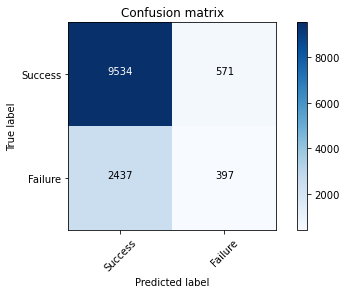

In [161]:
# Defining the kNNClassifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors = 6)
#Fitting the classifier to the training set
knn.fit(X_train,y_train)
print ("kNN Accuracy is %2.2f" % accuracy_score(y_test, knn.predict(X_test)))
#The cross validation score is obtained for kNN using 10 folds
score_knn = cross_val_score(knn, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_knn)
y_pred= knn.predict(X_test)
print(classification_report(y_test, y_pred))
#Defining the confusion matrix
cm = confusion_matrix(y_test,y_pred)
#Plotting the confusion matrix
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

<a id='log'></a>
## Logistic Regression

Logistic Accuracy is 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87     10105
         1.0       0.39      0.03      0.05      2834

    accuracy                           0.78     12939
   macro avg       0.59      0.51      0.46     12939
weighted avg       0.70      0.78      0.69     12939



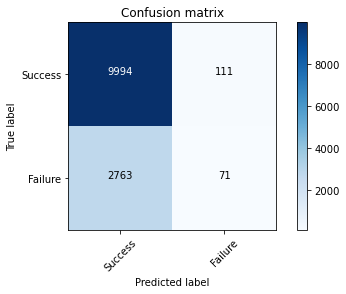

In [162]:
#Logistic Regression Classifier
LR = LogisticRegression()
LR.fit(X_train,y_train)
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_test, LR.predict(X_test)))
score_LR = cross_val_score(LR, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_LR)
y_pred = LR.predict(X_test)
print(classification_report(y_test, y_pred))
# Confusion matrix for LR
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

<a id='svm'></a>
## SVM

SVM Accuracy is 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     10105
         1.0       0.47      0.01      0.02      2834

    accuracy                           0.78     12939
   macro avg       0.62      0.50      0.45     12939
weighted avg       0.71      0.78      0.69     12939



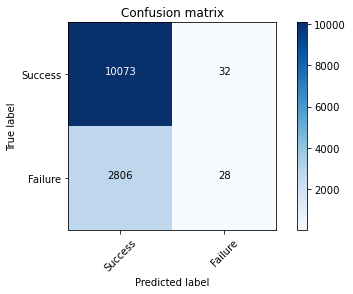

In [163]:
#SVM Classifier
SVM = svm.SVC()
SVM.fit(X_train, y_train)
print ("SVM Accuracy is %2.2f" % accuracy_score(y_test, SVM.predict(X_test)))
score_svm = cross_val_score(SVM, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_svm)
y_pred = SVM.predict(X_test)
print(classification_report(y_test,y_pred))
#Confusion matrix for SVM
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

<a id='tree'></a>
## Decision Tree

Decision Tree Accuracy is 0.71
Cross Validation Score = 0.71
              precision    recall  f1-score   support

         0.0       0.86      0.74      0.80     10105
         1.0       0.39      0.58      0.46      2834

    accuracy                           0.71     12939
   macro avg       0.62      0.66      0.63     12939
weighted avg       0.76      0.71      0.72     12939



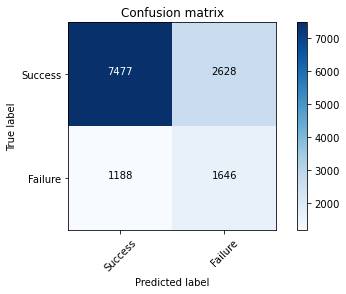

In [164]:
# Decision Tree Classifier
DT = tree.DecisionTreeClassifier(random_state = 0,class_weight="balanced",
    min_weight_fraction_leaf=0.01)
DT = DT.fit(X_train,y_train)
print ("Decision Tree Accuracy is %2.2f" % accuracy_score(y_test, DT.predict(X_test)))
score_DT = cross_val_score(DT, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_DT)
y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))
# Confusion Matrix for Decision Tree
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

<a id='ran'></a>
## Random Forest

Random Forest Accuracy is 0.71
Cross Validation Score = 0.72
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81     10105
         1.0       0.38      0.49      0.43      2834

    accuracy                           0.71     12939
   macro avg       0.61      0.63      0.62     12939
weighted avg       0.74      0.71      0.73     12939



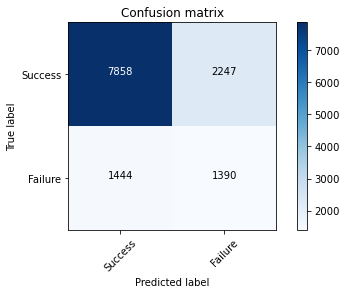

In [165]:
#Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10,class_weight="balanced")
rfc.fit(X_train, y_train)
print ("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, rfc.predict(X_test)))
score_rfc = cross_val_score(rfc, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_rfc)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred ))
#Confusion Matrix for Random Forest
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

<a id='ada'></a>
## AdaBoost

AdaBoost Accuracy= 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88     10105
         1.0       0.51      0.04      0.08      2834

    accuracy                           0.78     12939
   macro avg       0.65      0.52      0.48     12939
weighted avg       0.73      0.78      0.70     12939



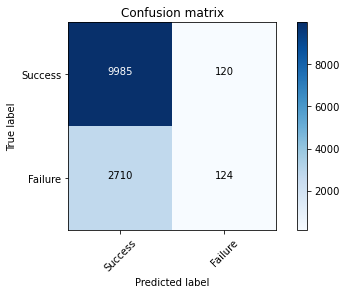

In [166]:
#AdaBoost Classifier
ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
ada.fit(X_train,y_train)
print ("AdaBoost Accuracy= %2.2f" % accuracy_score(y_test,ada.predict(X_test)))
score_ada = cross_val_score(ada, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_ada)
y_pred = ada.predict(X_test)
print(classification_report(y_test,y_pred ))
#Confusion Marix for AdaBoost
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

<a id='xgb'></a>
## XGBOOST

GradientBoost Accuracy= 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88     10105
         1.0       0.50      0.05      0.08      2834

    accuracy                           0.78     12939
   macro avg       0.64      0.52      0.48     12939
weighted avg       0.72      0.78      0.70     12939



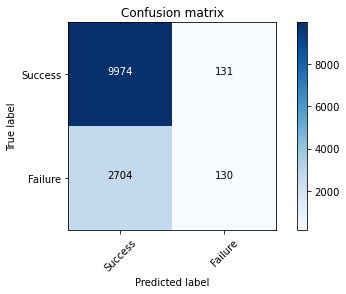

In [167]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

#XGBoost Classifier
xgb = GradientBoostingClassifier(n_estimators=1000,learning_rate=0.01)
xgb.fit(X_train , y_train)
print ("GradientBoost Accuracy= %2.2f" % accuracy_score(y_test,xgb.predict(X_test)))
score_xgb = cross_val_score(xgb, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_xgb)
y_pred = xgb.predict(X_test) 
print(classification_report(y_test,y_pred))
#Confusion Matrix for XGBoost Classifier
cm_xg = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm_xg, classes=class_names, title='Confusion matrix')

<a id='gbm'></a>
## LIGHTGBM

In [168]:
# pip install lightgbm

LightGBM Accuracy= 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87     10105
         1.0       0.43      0.03      0.06      2834

    accuracy                           0.78     12939
   macro avg       0.61      0.51      0.47     12939
weighted avg       0.71      0.78      0.70     12939



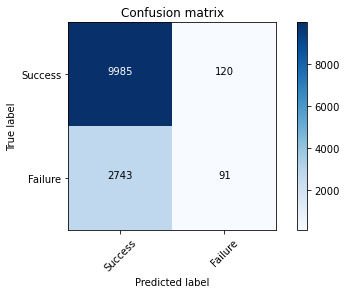

In [169]:
#lightgbm Classifier
from lightgbm import LGBMClassifier
# parameters={'n_estimators':[900,1000,1100],
#             'learning_rate':[0.01],
#             'max_depth':[8],
#             'min_child_weight':[1],
#             'subsample':[0.8],
#             'colsample_bytree':[0.3,0.4,0.5]}
lgb = LGBMClassifier(n_estimators=1100, learning_rate=0.01, max_depth=4, min_child_weight=1, subsample=0.8, \
                     colsample_bytree=0.5, num_leaves=100)

lgb.fit(X_train,y_train)
print ("LightGBM Accuracy= %2.2f" % accuracy_score(y_test,lgb.predict(X_test)))
score_lgb = cross_val_score(lgb, X, y, cv=10).mean()
print("Cross Validation Score = %2.2f" % score_lgb)
y_pred = lgb.predict(X_test)
print(classification_report(y_test, y_pred))
#Confusion Marix for lightgbm
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

<a id='roc'></a>
## ROC Curves
> Applying Reciever Operating Characteristic(ROC) Curves to plot the true positive rate and the false postive rates so that we can determine which model works best.

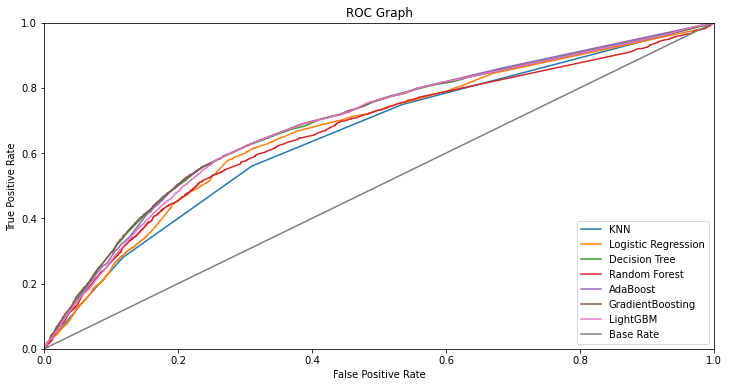

In [170]:
#Obtaining False Positive Rate, True Positive Rate and Threshold for all classifiers
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
#SVM_fpr, SVM_tpr, thresholds = roc_curve(y_test, SVM.predict_proba(X_test)[:,1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:,1])
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, thresholds = roc_curve(y_test, ada.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
lgb_fpr, lgb_tpr, thresholds = roc_curve(y_test, lgb.predict_proba(X_test)[:,1])
#PLotting ROC Curves for all classifiers
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label='KNN' )
plt.plot(LR_fpr, LR_tpr, label='Logistic Regression')
#plt.plot(SVM_fpr, SVM_tpr, label='SVM')
plt.plot(DT_fpr, DT_tpr, label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest')
plt.plot(ada_fpr, ada_tpr, label='AdaBoost')
plt.plot(xgb_fpr, xgb_tpr, label='GradientBoosting')
plt.plot(lgb_fpr, lgb_tpr, label='LightGBM')
# Plot Base Rate ROC

plt.plot([0,1],[0,1],label='Base Rate')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

AdaBoost, GradientBoosting, LightGBM are doing their part well with good accuracy scores, less true negatives.

<a id='con'></a>
# Conclusion:

Suggestion:
1. Train the employees working in the Call Center with people skills so that during call they can be more friendly and engaging.
2. Maintain a tracker which reminds of follow-ups so that the representative can talk to the person again and try to convince them in purchasing 6sense product.
3. Contact persons from the previous company who responded since they are more likely to buy their product.
